In [22]:
# Install dependencies if missing (uncomment if needed)
# %pip install tensorflow pandas numpy scikit-learn joblib matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
import joblib

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


In [23]:
# Define paths relative to this notebook
DATA_DIR = '../data/processed'  # Assuming your CSVs are in a folder named 'data' one level up
ag_path = os.path.join(DATA_DIR, 'data_set_AG_1.csv')
mal_path = os.path.join(DATA_DIR, 'data_set_MAL_1.csv')

# Load Datasets
print("Loading datasets...")
try:
    ag_df = pd.read_csv(ag_path)
    mal_df = pd.read_csv(mal_path)
    print(f"Loaded AG Data: {ag_df.shape}")
    print(f"Loaded MAL Data: {mal_df.shape}")
except FileNotFoundError:
    print("Error: Files not found. Please ensure data_set_AG_1.csv and MAL_1.csv are in the '../data' folder.")

Loading datasets...
Loaded AG Data: (1000, 11)
Loaded MAL Data: (1000, 11)


In [24]:
# Select features (excluding non-numeric cols like 'type', 'sender', 'to')
numeric_cols = ['approveAmount', 'transferAmount', 'transferFromAmount', 
                'oldApproveState', 'newApproveState', 'oldBalanceState', 
                'newBalanceState', 'success'] # 'success' is boolean, convert to int

# Clean Data
train_data = ag_df[numeric_cols].copy()
train_data['success'] = train_data['success'].astype(int)

# Normalize Data (Crucial for Neural Networks)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_data)
print(f"Data Scaled. Shape: {X_train.shape}")

Data Scaled. Shape: (1000, 8)


In [25]:
# Function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

SEQUENCE_LENGTH = 20
X_train_seq = create_sequences(X_train, SEQUENCE_LENGTH)
print(f"Sequences created. Shape: {X_train_seq.shape}") 
# Expected: (Samples, 20, 8)

Sequences created. Shape: (980, 20, 8)


In [26]:
# Define the Recurrent Autoencoder
model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(X_train_seq.shape[1]),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train_seq.shape[2]))
])

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 20, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 20, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 20, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 8)          │           520 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,776 (253.03 KB)

 Trainable params: 64,776 (253.03 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(
    X_train_seq, X_train_seq,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.3730 - val_loss: 0.2676
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2319 - val_loss: 0.1909
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1901 - val_loss: 0.1712
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1806 - val_loss: 0.1652
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1755 - val_loss: 0.1598
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1751 - val_loss: 0.1632
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1716 - val_loss: 0.1561
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1697 - val_loss: 0.1570
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1705 - val_loss: 0.1554
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1702 - val_loss: 0.1542
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1690 - val_loss: 0.1558
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1

In [28]:
# Create models directory if it doesn't exist
save_dir = '../models'
os.makedirs(save_dir, exist_ok=True)

# 1. Save Model
model_save_path = os.path.join(save_dir, 'fraud_detection_model.h5')
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

# 2. Save Scaler
scaler_save_path = os.path.join(save_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_save_path)
print(f"Scaler saved to: {scaler_save_path}")

Model saved to: ../models\fraud_detection_model.h5
Scaler saved to: ../models\scaler.pkl


Processing Malicious Data...
Malicious Sequences Shape: (980, 20, 8)
Generating predictions...


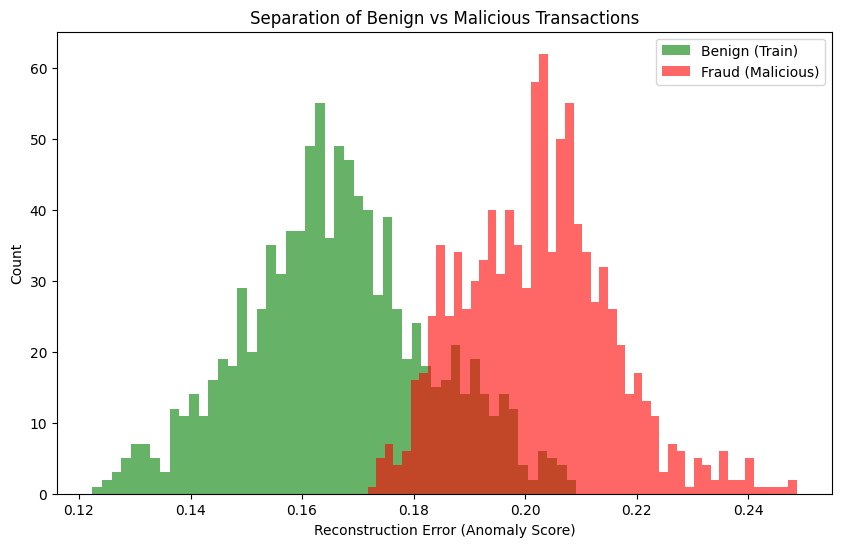

New Calculated Threshold: 0.1951

--- FINAL PERFORMANCE ---
Accuracy:  0.8168
Precision: 0.9318
Recall:    0.6837
F1-Score:  0.7887


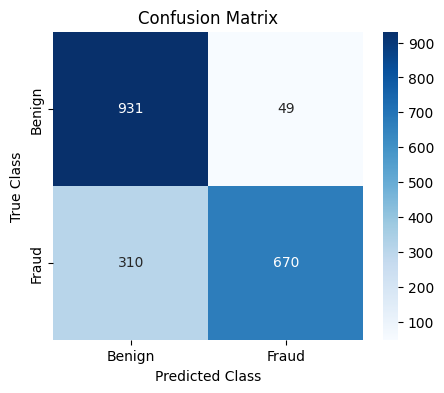

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. PREPARE MALICIOUS DATA ---
# Ensure we have the malicious sequences ready
print("Processing Malicious Data...")
numeric_cols = ['approveAmount', 'transferAmount', 'transferFromAmount', 
                'oldApproveState', 'newApproveState', 'oldBalanceState', 
                'newBalanceState', 'success']

# Scale Malicious Data
X_mal = scaler.transform(mal_df[numeric_cols])

# Create Sequences
def create_sequences_local(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

X_mal_seq = create_sequences_local(X_mal, SEQUENCE_LENGTH)
print(f"Malicious Sequences Shape: {X_mal_seq.shape}")

# --- 2. GENERATE PREDICTIONS ---
print("Generating predictions...")

# Predict on Benign
benign_pred = model.predict(X_train_seq, verbose=0)
# FIX: axis=(1,2) flattens the error to a single number per transaction
benign_loss = np.mean(np.abs(benign_pred - X_train_seq), axis=(1, 2))

# Predict on Malicious
malicious_pred = model.predict(X_mal_seq, verbose=0)
# FIX: axis=(1,2) flattens the error to a single number per transaction
malicious_loss = np.mean(np.abs(malicious_pred - X_mal_seq), axis=(1, 2))

# --- 3. VISUALIZE SEPARATION ---
plt.figure(figsize=(10, 6))
plt.hist(benign_loss, bins=50, alpha=0.6, label='Benign (Train)', color='green')
plt.hist(malicious_loss, bins=50, alpha=0.6, label='Fraud (Malicious)', color='red')
plt.xlabel('Reconstruction Error (Anomaly Score)')
plt.ylabel('Count')
plt.title('Separation of Benign vs Malicious Transactions')
plt.legend()
plt.show()

# --- 4. CALCULATE METRICS ---
# Threshold: 95th percentile of benign loss
threshold = np.percentile(benign_loss, 95) 
print(f"New Calculated Threshold: {threshold:.4f}")

# Truth vs Prediction
y_true = np.concatenate([np.zeros(len(benign_loss)), np.ones(len(malicious_loss))])
all_losses = np.concatenate([benign_loss, malicious_loss])
y_pred = [1 if loss > threshold else 0 for loss in all_losses]

# --- 5. FINAL SCORES ---
print("\n--- FINAL PERFORMANCE ---")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_true, y_pred):.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Fraud'], yticklabels=['Benign', 'Fraud'])
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()